In [1]:
import numpy as np
from astropy.io import ascii 
import matplotlib.pyplot as plt 
from matplotlib import cm
import pandas as pd
%matplotlib inline

In [2]:
#reads the data and tests for correct input
data = ascii.read('Astr511HW1data.dat.txt',format='commented_header') #commented_head use this in jupyter notebooks
print(data[:10])
 ##    ra        dec   run     Ar      u      g      r      i      z  uErr  gErr  rErr  iErr  zErr    pmL    pmB    pmErr

    ra      dec    run   Ar    u     g   ... rErr iErr zErr  pmL   pmB   pmErr
--------- -------- ---- ---- ----- ----- ... ---- ---- ---- ----- ------ -----
 181.6122  27.5726 5087 0.05  16.4 15.24 ... 0.02 0.02 0.01  5.16  -1.45  2.72
181.61303  27.6077 5087 0.05 21.84 19.55 ... 0.02 0.02 0.02  5.48   4.73  3.16
181.61416 27.35956 5112 0.05 19.76 17.56 ... 0.02 0.03 0.03  3.14   7.92  2.79
 181.6164 27.82464 5112 0.06 21.73 20.63 ... 0.03 0.03 0.13 19.13  -1.08  5.08
181.62112 28.01623 5087 0.05 21.37 20.38 ... 0.03 0.03 0.09 -3.65   -8.0  4.91
181.62252 27.63987 5087 0.05 17.34 15.58 ... 0.02 0.02 0.01  9.74 -10.64  2.72
181.62469 27.32682 5112 0.05 21.63 20.52 ... 0.03 0.04 1.07  6.73 -25.39  5.13
181.62582 27.42162 5112 0.05 23.16 21.09 ... 0.02 0.03 0.04 35.17    7.8  4.18
181.63178 26.93836 5112 0.05 18.57 15.96 ... 0.02 0.02 0.02 15.96  -8.01  2.72
181.63364 27.24131 5087 0.06  20.9 18.78 ... 0.02 0.02 0.02  2.03  -5.43  2.96


In [3]:
#computes metallicity function [Bond et al. 2010]
def metallicity(x,y):
    """
    Calculates metallicity [Bond et al. 2010]
        
            Parameters:
                x( float array): u-g SDSS band
                y( float array): g-r SDSS band
            Returns:
                metallicity (float array): Fe/H
    """
    #defines best-fit coefficients given by Bond et al. in array type from A-J
    A=-13.13
    B= 14.09
    C= 28.04
    D= -5.51
    E= -5.90
    F= -58.68
    G= 9.14
    H= -20.61
    I= 0.0
    J= 58.20
    #creates empty array to allocate results 
    metallicityArray = np.empty(y.size)
    metallicityArray[:] = 0
    #loops through  data 
    for i in range (y.size):
        if(y[i] < 0.6 ):    
        #appends to resulting metallicity array and computes the formula. This seems very tricky but it's simple don't panick h
            metallicityArray[i] = A+B*x[i]+C*y[i]+D*x[i]*y[i]+E*(x[i]**2)+F*(y[i]**2)+G*((x[i])**2)*y[i]+H*x[i]*((y[i])**2)+I*((x[i])**3)+J*(y[i]**3)
        else:
            metallicityArray[i] = -0.6
    return metallicityArray
    # metallicityArray[i] = A + B*x[i]+ C*y[i] + D*x[i]*y[i] + E*pow(x,2) + F*pow(y,2)+G*pow(x,2)*y + H*pow(y,2)*x + I*pow(x,3)+J*pow(y,3)


In [4]:
#tests metallicity function
x = np.array(data['u'] - data['g'])
y = np.array(data['g'] - data['r'])
FeH = metallicity(x,y)
print(FeH)

[-0.8191296 -0.6       -0.6       ... -0.6       -0.6       -0.6      ]


In [5]:
#computes absolute magnitude using photometric parallax relationship [Ivezić et al. 2008]
def abs_mag(band):
    """
    Calculates absolute magnitudes [Bond et al. 2010]
        
            Parameters:
                band( float array): g-i SDSS band
            Returns:
                absolute magnitudes(float array)
    """
    #defines an empty array to return result
    absolute_magnitude = np.empty(band.size)
    #computes metallicity with previous function
    metas = metallicity(x,y)
    #loops through the arrays
    for i in range(band.size):
        mgn_metallicity = 4.50 -1.11*metas[i] -0.18*pow(metas[i],2)
        #A7
        mgn_band = -5.06  +14.32*band[i] - 12.97*pow(band[i],2) + 6.127*pow(band[i],3) - 1.267*pow(band[i],4) + 0.0967*pow(band[i],5)
        #A4
        absolute_magnitude[i] = mgn_band + mgn_metallicity
    return absolute_magnitude

In [6]:
#test abs_mag function
z = np.array(data['g'] - data['i'])
mag = abs_mag(z)
print(mag[:50])

[4.88853564 7.35863457 6.99674651 5.64485961 3.93777605 6.21245575
 4.16177266 8.80018053 7.81967066 7.13325661 6.6090974  7.15312504
 9.00008196 5.87101687 5.19660953 5.58187673 6.30386407 7.67323561
 5.60238331 6.51519194 5.35027913 6.61439034 6.16487668 5.30720682
 3.19556732 4.52877622 6.21245575 3.63096175 7.19319385 8.13587644
 4.6269505  8.76762222 4.86438559 8.54593156 5.95950349 5.2726
 5.48947639 7.92153682 4.85531136 6.39095648 8.89916384 9.172468
 8.00023676 5.33635662 4.64081984 6.32601057 5.20893682 5.40817644
 6.67260076 5.29597751]


In [7]:
#computes distance using a function
def distance(absolutes,apparent):
    """
    Calculates distances in parsecs
        
            Parameters:
                Absolute: float array of absolute magnitude of a particular band
                Apparent: float array of apparent magnitude of a particular band
            Returns:
                distances in parsecs(float array)
    """
    #creates an empty array to return 
    formula = np.empty(absolutes.size)
    formula = (apparent - absolutes)/5
    result = np.power(10,formula)*10
    return result

In [8]:
#tests for distance(absolute,apparent) function
distanceParsec = distance(mag,np.array(data['r']))
print(distanceParsec)

[ 960.04783539 1615.37399051  836.85593009 ...  248.34974785  473.49750882
 1338.20802884]


In [9]:
#computes function to calculate volume
def volume_function(distance):
    #creates an empty array to return
    result = np.empty(distance.size)
    result[:] = 0
    for i in range(distance.size):
        result[i] = 4/3*np.pi*distance[i]**3
    return result
# volumes = 4/3*np.pi*distancesCool**3 [use for testing]

In [10]:
vol = volume_function(distanceParsec)
print(vol)

[3.70652751e+09 1.76566321e+10 2.45493899e+09 ... 6.41622787e+07
 4.44673967e+08 1.00382846e+10]


The number of stars within target range: 107673.000000 stars
The maximum distance is: 98928.784738 parsec
The minimum distance is: 577.277196 parsec


No handles with labels found to put in legend.


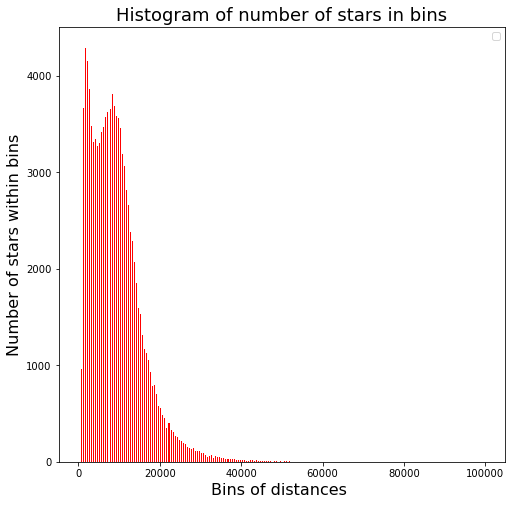

In [11]:
'Defines bin of volumes and plots distributions'
#counts number of interesting ojects
ctr = 0
for i in range(y.size):# `y` is the array containing g-r. There are more efficient ways to do this
    if y[i] < 0.4 and y[i] > 0.2:
        ctr += 1
#creates tuple array that matches conditions
is_target = np.empty(y.size)
for i in range(y.size):
    if (0.2 < y[i] and 0.4 > y[i]):
        is_target[i] = True
#extracts target values of g-r band using the previously created tupple array
target_bands = np.extract(is_target,y)
other_bands = np.extract(is_target,x)
txt = "The number of stars within target range: {num:.6f} stars"
print(txt.format(num = target_bands.size))
#get distances of these values
target_distances = np.extract(is_target,distanceParsec)

txt1 = "The maximum distance is: {number1:.6f} parsec"
print(txt1.format(number1 = np.amax(target_distances)))
txt2 = "The minimum distance is: {number2:.6f} parsec"
print(txt2.format(number2 = np.amin(target_distances)))


#THREE: Plots distritbution of these stars 
bins=np.linspace(0,100000,201)
plt.figure(figsize=(8,8))
plt.hist(target_distances, bins,color = 'red',histtype='bar', rwidth=0.5)
plt.title('Histogram of number of stars in bins',fontsize =18)
plt.xlabel('Bins of distances ', fontsize = 16)
plt.ylabel('Number of stars within bins',fontsize = 16)
plt.legend()
plt.show()

C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/2339438052.py:23: RuntimeWarning: invalid value encountered in true_divide
  densitiesArrayOne = target_ctrOne/target_volumesOne
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/2339438052.py:26: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayOne),'^',color = 'red')


(-23.0, -15.0)

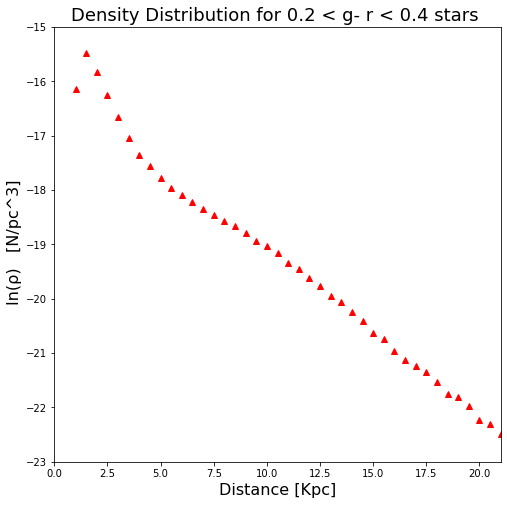

In [12]:
'Computes and plots the densities and distances. SORTED'
#writes a table with astropy with target_band and their respective distances
from astropy.table import Table
dat = Table()
dat['g-r'] = target_bands
dat['u-g'] = other_bands
dat['distance'] = target_distances
ascii.write(dat, 'values.dat', overwrite=True) 
dat = ascii.read('values.dat',format='basic') #commented_head use this in jupyter notebooks
#sorts table with respect to their distances from small to big.
dat.sort('distance')
#calculate their volumes
target_distanceOne = np.array(dat['distance'])
target_volumesOne = np.empty(bins.size)
for i in range(bins.size-1):
    target_volumesOne[i]= 4/3*np.pi*pow(bins[i+1],3) - 4/3*np.pi*pow(bins[i],3)
#calulates number of stars 
target_ctrOne = np.zeros(bins.size)
for i in range(1,bins.size):
    for j in range(target_distanceOne.size):
        if (target_distanceOne[j] <= bins[i] and target_distanceOne[j] > bins[i-1]): #
            target_ctrOne[i] += 1
densitiesArrayOne = target_ctrOne/target_volumesOne
#print(densitiesArrayTwo)
plt.figure(figsize=(8,8))
plt.plot(bins/1000,np.log(densitiesArrayOne),'^',color = 'red')
plt.title('Density Distribution for 0.2 < g- r < 0.4 stars ', fontsize =18)
plt.xlabel('Distance [Kpc]',fontsize = 16)
plt.ylabel(' ln(ρ)   [N/pc^3]',fontsize = 16)
plt.xlim(0,21)
plt.ylim(-23,-15)

(-8.0, 2.0)

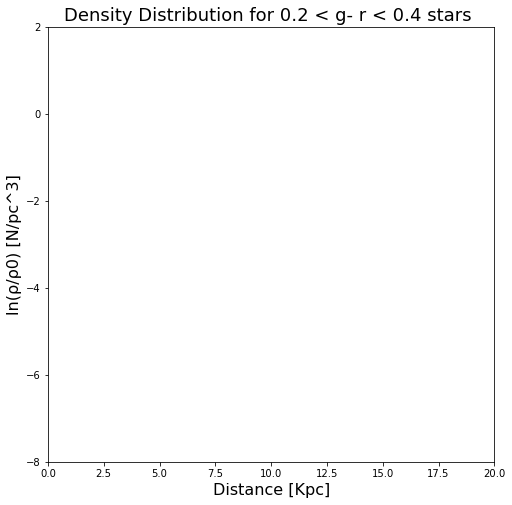

In [13]:
#Stadarizes plot in reference to the paper
maxDensity = np.amax(densitiesArrayOne)
plt.figure(figsize=(8,8))
plt.plot(bins/1000,np.log(densitiesArrayOne/maxDensity),'^',color = 'red')
plt.title('Density Distribution for 0.2 < g- r < 0.4 stars ', fontsize =18)
plt.xlabel('Distance [Kpc]',fontsize = 16)
plt.ylabel('ln(ρ/ρ0) [N/pc^3]',fontsize = 16)
plt.xlim(0,20)
plt.ylim(-8,2)

No handles with labels found to put in legend.


The number of stars within target range: 92299.000000 stars
The maximum distance is: 46362.112668 parsec
The minimum distance is: 358.669166 parsec


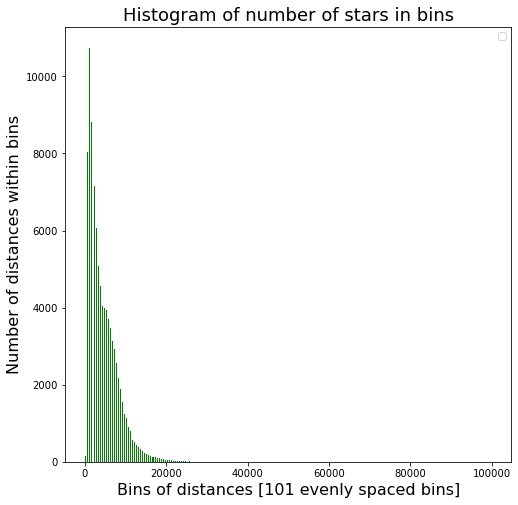

In [14]:
#2  Second range: 0.4  g-r <0.6
'Defines bin of volumes and plots distributions'
#counts number of interesting ojects
ctrTwo = 0
for i in range(y.size):# `y` is the array containing g-r. There are more efficient ways to do this
    if y[i] < 0.6 and y[i] > 0.4:
        ctrTwo += 1
#creates tuple array that matches conditions
is_targetTwo = np.empty(y.size)
for i in range(y.size):
    if (0.4 < y[i] and 0.6 > y[i]):
        is_targetTwo[i] = True
#extracts target values of g-r band using the previously created tupple array
target_bandsTwo = np.extract(is_targetTwo,y)
txt = "The number of stars within target range: {num:.6f} stars"
print(txt.format(num = target_bandsTwo.size))
#get distances of these values
target_distancesTwo = np.extract(is_targetTwo,distanceParsec)

txt1 = "The maximum distance is: {number1:.6f} parsec"
print(txt1.format(number1 = np.amax(target_distancesTwo)))
txt2 = "The minimum distance is: {number2:.6f} parsec"
print(txt2.format(number2 = np.amin(target_distancesTwo)))


#THREE: Plots distritbution of these stars 
bins=np.linspace(0,100000,201)
plt.figure(figsize=(8,8))
plt.hist(target_distancesTwo, bins,color= 'green',  histtype='bar', rwidth=0.5)
plt.title('Histogram of number of stars in bins',fontsize =18)
plt.xlabel('Bins of distances [101 evenly spaced bins]', fontsize = 16)
plt.ylabel('Number of distances within bins',fontsize = 16)
plt.legend()
plt.show()

C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/77091436.py:22: RuntimeWarning: invalid value encountered in true_divide
  densitiesArrayTwo = target_ctrTwo/target_volumesTwo
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/77091436.py:25: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayTwo),'^',color = 'green')


Text(0, 0.5, ' ln(ρ)   [N/pc^3]')

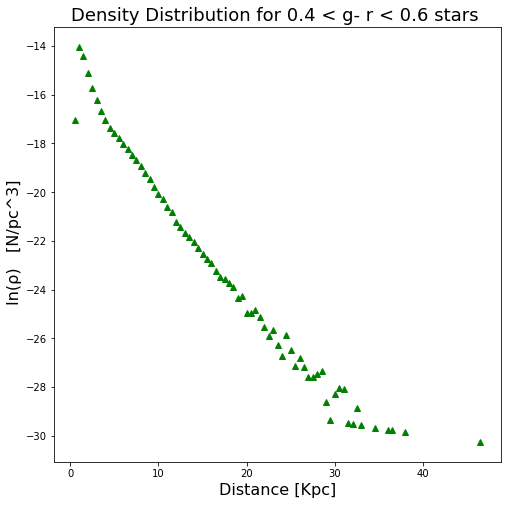

In [15]:
'Computes and plots the densities and distances. SORTED'
#writes a table with astropy with target_band and their respective distances
from astropy.table import Table
datTwo = Table()
datTwo['g-r'] = target_bandsTwo
datTwo['distance'] = target_distancesTwo
ascii.write(datTwo, 'values.dat', overwrite=True) 
datTwo = ascii.read('values.dat',format='basic') #commented_head use this in jupyter notebooks
#sorts table with respect to their distances from small to big.
datTwo.sort('distance')
#calculate their volumes
target_distanceTwo = np.array(datTwo['distance'])
target_volumesTwo = np.empty(bins.size)
for i in range(bins.size-1):
    target_volumesTwo[i]= 4/3*np.pi*pow(bins[i+1],3) - 4/3*np.pi*pow(bins[i],3)
#calulates number of stars 
target_ctrTwo = np.zeros(bins.size)
for i in range(1,bins.size):
    for j in range(target_distanceTwo.size):
        if (target_distanceTwo[j] <= bins[i] and target_distanceTwo[j] > bins[i-1]): #
            target_ctrTwo[i] += 1
densitiesArrayTwo = target_ctrTwo/target_volumesTwo
#print(densitiesArrayTwo)
plt.figure(figsize=(8,8))
plt.plot(bins/1000,np.log(densitiesArrayTwo),'^',color = 'green')
plt.title('Density Distribution for 0.4 < g- r < 0.6 stars ', fontsize =18)
plt.xlabel('Distance [Kpc]',fontsize = 16)
plt.ylabel(' ln(ρ)   [N/pc^3]',fontsize = 16)

No handles with labels found to put in legend.


The number of stars within target range: 49386.000000 stars
The maximum distance is: 14014.888182 parsec
The minimum distance is: 311.159016 parsec


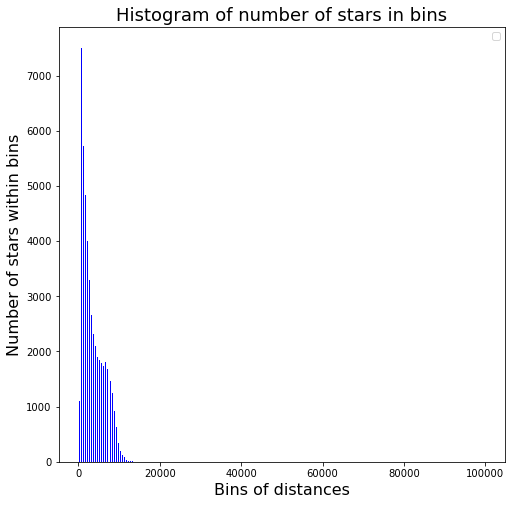

<Figure size 432x288 with 0 Axes>

In [16]:
#3  Thrid range: 0.6  g-r <0.8
'Defines bin of volumes and plots distributions'
#counts number of interesting ojects
ctrThree = 0
for i in range(y.size):# `y` is the array containing g-r. There are more efficient ways to do this
    if y[i] < 0.8 and y[i] > 0.6:
        ctrThree += 1
#creates tuple array that matches conditions
is_targetThree = np.empty(y.size)
for i in range(y.size):
    if (0.6 < y[i] and 0.8 > y[i]):
        is_targetThree[i] = True
#extracts target values of g-r band using the previously created tupple array
target_bandsThree = np.extract(is_targetThree,y)
txt = "The number of stars within target range: {num:.6f} stars"
print(txt.format(num = target_bandsThree.size))
#get distances of these values
target_distancesThree = np.extract(is_targetThree,distanceParsec)

txt1 = "The maximum distance is: {number1:.6f} parsec"
print(txt1.format(number1 = np.amax(target_distancesThree)))
txt2 = "The minimum distance is: {number2:.6f} parsec"
print(txt2.format(number2 = np.amin(target_distancesThree)))


#THREE: Plots distritbution of these stars 
bins=np.linspace(0,100000,201)
plt.figure(figsize=(8,8))
plt.hist(target_distancesThree, bins,color= 'blue',  histtype='bar', rwidth=0.5)
plt.title('Histogram of number of stars in bins',fontsize =18)
plt.xlabel('Bins of distances', fontsize = 16)
plt.ylabel('Number of stars within bins',fontsize = 16)
plt.legend()
plt.show()
plt.savefig('histogram.png', facecolor="white", edgecolor="none")

C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/1386311871.py:25: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayThree),'^',color = 'blue')


Text(0, 0.5, ' ln(ρ)   [N/pc^3]')

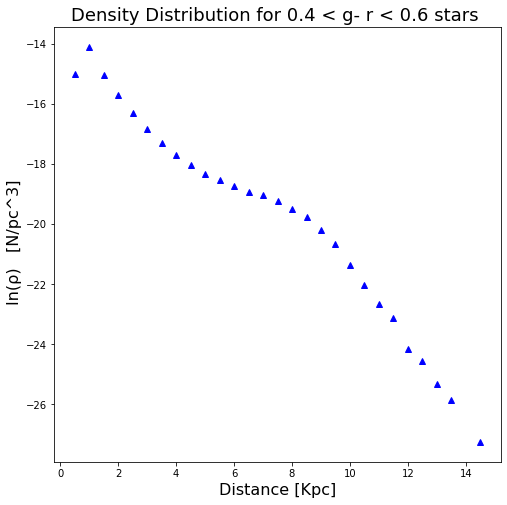

In [17]:
'Computes and plots the densities and distances. SORTED'
#writes a table with astropy with target_band and their respective distances
from astropy.table import Table
datThree = Table()
datThree['g-r'] = target_bandsThree
datThree['distance'] = target_distancesThree
ascii.write(datThree, 'values.dat', overwrite=True) 
datThree = ascii.read('values.dat',format='basic') #commented_head use this in jupyter notebooks
#sorts table with respect to their distances from small to big.
datThree.sort('distance')
#calculate their volumes
target_distanceThree = np.array(datThree['distance'])
target_volumesThree = np.empty(bins.size)
for i in range(bins.size-1):
    target_volumesThree[i]= 4/3*np.pi*pow(bins[i+1],3) - 4/3*np.pi*pow(bins[i],3)
#calulates number of stars 
target_ctrThree = np.zeros(bins.size)
for i in range(1,bins.size):
    for j in range(target_distanceThree.size):
        if (target_distanceThree[j] <= bins[i] and target_distanceThree[j] > bins[i-1]): #
            target_ctrThree[i] += 1
densitiesArrayThree = target_ctrThree/target_volumesThree
#print(densitiesArrayTwo)
plt.figure(figsize=(8,8))
plt.plot(bins/1000,np.log(densitiesArrayThree),'^',color = 'blue')
plt.title('Density Distribution for 0.4 < g- r < 0.6 stars ', fontsize =18)
plt.xlabel('Distance [Kpc]',fontsize = 16)
plt.ylabel(' ln(ρ)   [N/pc^3]',fontsize = 16)

No handles with labels found to put in legend.


The number of stars within target range: 36206.000000 stars
The maximum distance is: 8929.941944 parsec
The minimum distance is: 254.056290 parsec


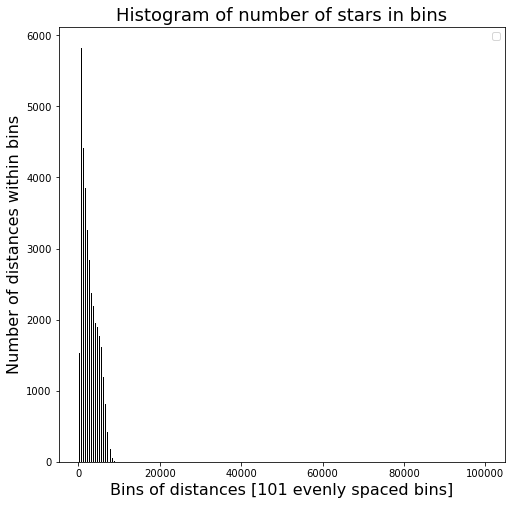

In [18]:
#4  Fourth range: 0.8  g-r < 1.0
'Defines bin of volumes and plots distributions'
#counts number of interesting ojects
ctrFour = 0
for i in range(y.size):# `y` is the array containing g-r. There are more efficient ways to do this
    if y[i] < 1.0 and y[i] > 0.8:
        ctrFour += 1
#creates tuple array that matches conditions
is_targetFour = np.empty(y.size)
for i in range(y.size):
    if (0.8 < y[i] and 1.0 > y[i]):
        is_targetFour[i] = True
#extracts target values of g-r band using the previously created tupple array
target_bandsFour = np.extract(is_targetFour,y)
txt = "The number of stars within target range: {num:.6f} stars"
print(txt.format(num = target_bandsFour.size))
#get distances of these values
target_distancesFour = np.extract(is_targetFour,distanceParsec)

txt1 = "The maximum distance is: {number1:.6f} parsec"
print(txt1.format(number1 = np.amax(target_distancesFour)))
txt2 = "The minimum distance is: {number2:.6f} parsec"
print(txt2.format(number2 = np.amin(target_distancesFour)))


#THREE: Plots distritbution of these stars 
bins=np.linspace(0,100000,201)
plt.figure(figsize=(8,8))
plt.hist(target_distancesFour, bins,color= 'black',  histtype='bar', rwidth=0.5)
plt.title('Histogram of number of stars in bins',fontsize =18)
plt.xlabel('Bins of distances [101 evenly spaced bins]', fontsize = 16)
plt.ylabel('Number of distances within bins',fontsize = 16)
plt.legend()
plt.show()

C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/1491236786.py:22: RuntimeWarning: invalid value encountered in true_divide
  densitiesArrayFour = target_ctrFour/target_volumesFour
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/1491236786.py:24: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayFour),'^',color = 'black')


Text(0, 0.5, ' ln(ρ)   [N/pc^3]')

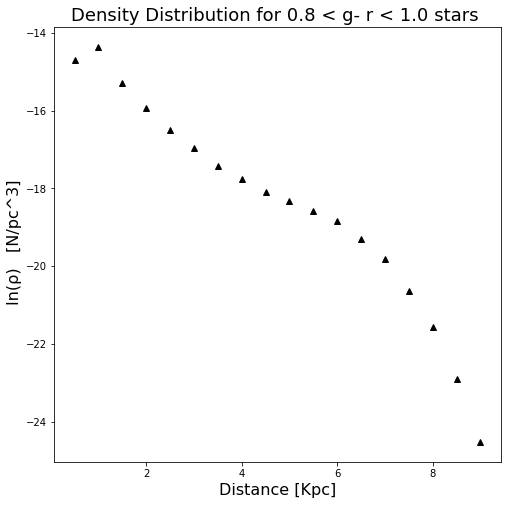

In [19]:
'Computes and plots the densities and distances. SORTED'
#writes a table with astropy with target_band and their respective distances
from astropy.table import Table
datFour = Table()
datFour['g-r'] = target_bandsFour
datFour['distance'] = target_distancesFour
ascii.write(datFour, 'values.dat', overwrite=True) 
datFour = ascii.read('values.dat',format='basic') #commented_head use this in jupyter notebooks
#sorts table with respect to their distances from small to big.
datFour.sort('distance')
#calculate their volumes
target_distanceFour = np.array(datFour['distance'])
target_volumesFour = np.empty(bins.size)
for i in range(bins.size-1):
    target_volumesFour[i]= 4/3*np.pi*pow(bins[i+1],3) - 4/3*np.pi*pow(bins[i],3)
#calulates number of stars 
target_ctrFour = np.zeros(bins.size)
for i in range(1,bins.size):
    for j in range(target_distanceFour.size):
        if (target_distanceFour[j] <= bins[i] and target_distanceFour[j] > bins[i-1]): #
            target_ctrFour[i] += 1
densitiesArrayFour = target_ctrFour/target_volumesFour
plt.figure(figsize=(8,8))
plt.plot(bins/1000,np.log(densitiesArrayFour),'^',color = 'black')
plt.title('Density Distribution for 0.8 < g- r < 1.0 stars ', fontsize =18)
plt.xlabel('Distance [Kpc]',fontsize = 16)
plt.ylabel(' ln(ρ)   [N/pc^3]',fontsize = 16)

C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/2273113118.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayOne),'^',color = 'red', label = '0.2 - 0.4')
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/2273113118.py:6: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayTwo),'^',color = 'green',label = '0.4 - 0.6')
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/2273113118.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayThree),'^',color = 'blue',label = '0.6 - 0.8')
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/2273113118.py:10: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(densitiesArrayFour),'^',color = 'black',label = '0.8 - 1.0')


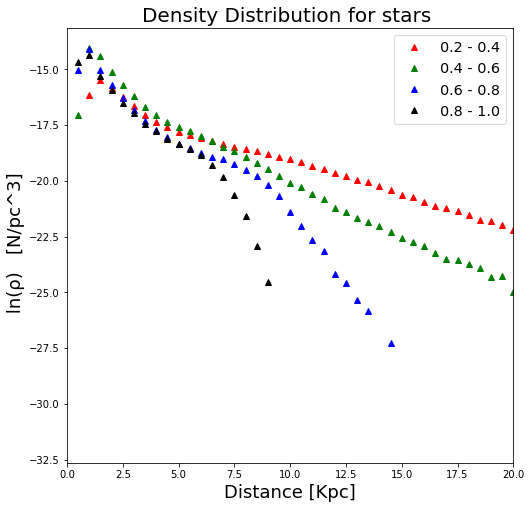

In [20]:
#Final Figure 
plt.figure(figsize=(8,8))
#0.2 < g-r <0.4
plt.plot(bins/1000,np.log(densitiesArrayOne),'^',color = 'red', label = '0.2 - 0.4')
#0.4 < g- r < 0.6
plt.plot(bins/1000,np.log(densitiesArrayTwo),'^',color = 'green',label = '0.4 - 0.6')
#0.6 < g-r < 0.8
plt.plot(bins/1000,np.log(densitiesArrayThree),'^',color = 'blue',label = '0.6 - 0.8')
#0.8 < g - r < 1.0
plt.plot(bins/1000,np.log(densitiesArrayFour),'^',color = 'black',label = '0.8 - 1.0')
plt.title('Density Distribution for stars ', fontsize =20)
plt.xlabel('Distance [Kpc]',fontsize = 18)
plt.ylabel(' ln(ρ)   [N/pc^3]',fontsize = 18)
plt.xlim(0,20)
plt.legend(fontsize = 'x-large')
plt.savefig('myfigure.png', facecolor="white", edgecolor="none")

In [69]:
#Question 3. Separate first range with with low and high metalicities and plot density distribution
#Test for constructed and sorted table with for target range 0.2 < g -r , 0.4
#uses the metallicity function to get the metallicities for given range
firstBand = dat['u-g'] 
secondBand = dat['g-r']
preciousMetals = metallicity(firstBand, secondBand) #creative #astroCode
#define the low-metallicites and high-metallicities arrays using ctr and arrays 
ctrMetalsLow = 0
ctrMetalsHigh = 0
for i in range(preciousMetals.size):
    if preciousMetals[i] < -1.0: 
        ctrMetalsLow += 1
    else:
        ctrMetalsHigh += 1
#creates the low-metallicities array of target band to plot 
isLow = np.empty(preciousMetals.size)
isHigh = np.empty(preciousMetals.size)
for i in range(preciousMetals.size):
    if preciousMetals[i] < -1.0:
        isLow[i] = True
        isHigh[i]=False
    else: 
        isLow[i] = False
        isHigh[i]=True
#adds to metallicity to table
dat['Low Metallicity'] = isLow
ascii.write(dat, 'values.dat', overwrite=True) 
print(dat)

        g-r                u-g              distance      Low Metallicity
------------------- ------------------ ------------------ ---------------
 0.3800000000000008 0.8399999999999999  577.2771955348113             1.0
0.39000000000000057 0.8800000000000008  577.5698064665577             1.0
  0.379999999999999 0.9900000000000002  581.6085724659118             1.0
  0.379999999999999 1.0999999999999996  592.4763543258225             0.0
0.39000000000000057 1.0099999999999998  624.5522062619095             1.0
 0.3899999999999988 1.0600000000000005  625.3563374232065             0.0
 0.3500000000000014 0.8199999999999985  630.7404284269758             1.0
 0.3200000000000003 0.8200000000000003  634.9820277147411             1.0
0.33999999999999986 0.9700000000000006  637.4673604442949             1.0
0.35999999999999943 0.9400000000000013  639.8494386924081             1.0
                ...                ...                ...             ...
0.21999999999999886 1.0500000000000007

C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/4287583028.py:24: RuntimeWarning: invalid value encountered in true_divide
  low_densities = ctr_low/target_volumesOne
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/4287583028.py:25: RuntimeWarning: invalid value encountered in true_divide
  high_densities = ctr_high/target_volumesOne
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/4287583028.py:28: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(low_densities),'^',color = 'blue',label = 'low')
C:\Users\cosme\AppData\Local\Temp/ipykernel_7084/4287583028.py:29: RuntimeWarning: divide by zero encountered in log
  plt.plot(bins/1000,np.log(high_densities),'^',color = 'red',label = 'high')


(-25.0, -15.0)

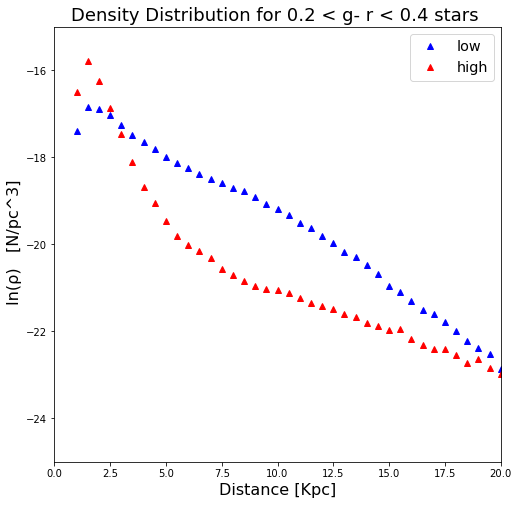

In [95]:
##ONE:Create an array with target values for lowBand and highBand[they will have different size] They are sorted
sortedTarget = np.array(dat['g-r'])
lowBand = np.extract(isLow,sortedTarget)
highBand = np.extract(isHigh,sortedTarget)
##TWO:Create histograms using bins for both lowBand and highBand
lowDistances = np.extract(isLow,target_distanceOne)
highDistances = np.extract(isHigh,target_distanceOne)
##THREE: Computes volumes of bins
#print(target_volumesOne.size)
##FOUR: Computes num of stars in bins
#low number of stars
ctr_low = np.zeros(bins.size)
for i in range(1,bins.size):
    for j in range(lowDistances.size):
        if (lowDistances[j] <= bins[i] and lowDistances[j] > bins[i-1]): #
            ctr_low[i] += 1
#high number of stars
ctr_high = np.zeros(bins.size)
for i in range(1,bins.size):
    for j in range(highDistances.size):
        if (highDistances[j] <= bins[i] and highDistances[j] > bins[i-1]): #
            ctr_high[i] += 1
##FIVE: Computes densities
low_densities = ctr_low/target_volumesOne
high_densities = ctr_high/target_volumesOne
##Six: Plots the density distribution
plt.figure(figsize=(8,8))
plt.plot(bins/1000,np.log(low_densities),'^',color = 'blue',label = 'low')
plt.plot(bins/1000,np.log(high_densities),'^',color = 'red',label = 'high')
plt.title('Density Distribution for 0.2 < g- r < 0.4 stars ', fontsize =18)
plt.xlabel('Distance [Kpc]',fontsize = 16)
plt.ylabel(' ln(ρ)   [N/pc^3]',fontsize = 16)
plt.legend(fontsize ='x-large')
plt.xlim(0,20)
plt.ylim(-25,-15)